# 📍 Recipe: Drawing a Pass Map

This example demonstrates how to visualize a player's passes using `Flow` to process StatsBomb data and `mplsoccer` to draw the pitch.

## 🧰 What You’ll Learn

- How to filter for completed passes
- How to extract pass start and end locations
- How to use `.assign()` to extract nested data as an alternative to using `.select()` + `.rename()`
- How to use `.split_array()` to extract the location array into multiple fields
- How to optimize the flow for better performance
- How to plot them using `mplsoccer`

## Imports

In [1]:
from penaltyblog.matchflow import Flow, where_equals, get_field, get_index
from mplsoccer import Pitch
import matplotlib.pyplot as plt

## Load the Data

In [2]:
# Load events for a StatsBomb match
match_id = 22912  # Champions League Final 2018/2019

flow = Flow.statsbomb.events(match_id)

## Extract the Passes

In [3]:
passes = (
    flow
    .filter(where_equals("type.name", "Pass"))
    .filter(where_equals("player.name", "Harry Kane"))
    .assign(
        outcome=lambda r: get_field("pass.outcome.name", "Successful")(r),
        end_location=lambda r: get_field("pass.end_location")(r),
    )
    .filter(where_equals("outcome", "Successful"))
    .split_array("location", ["start_x", "start_y"])
    .split_array("end_location", ["end_x", "end_y"])
    .select("start_x", "start_y", "end_x", "end_y")
    .collect()
)

## Plotting the Passes

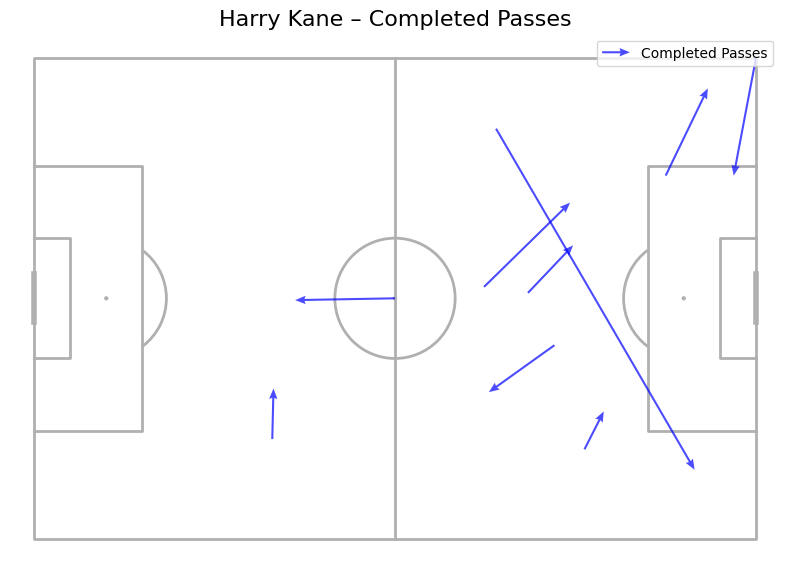

In [4]:
pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
fig, ax = pitch.draw(figsize=(8, 6))

pitch.arrows(
    [x["start_x"] for x in passes], 
    [x["start_y"] for x in passes],
    [x["end_x"] for x in passes], 
    [x["end_y"] for x in passes],
    ax=ax,
    width=1.5,
    headwidth=4,
    color='blue',
    label='Completed Passes',
    zorder=3,
    alpha=0.7
)

ax.set_title("Harry Kane – Completed Passes", fontsize=16)
plt.legend()
plt.show()

## Optimizing the Flow

The original `flow` we created is clean and idiomatic, but it’s not the most efficient - each `.filter()` and `.split_array()` call adds overhead by making separate passes through the data.

For better performance, especially with larger datasets, we can combine these steps into single `.filter()` and `.assign()` operations. This approach extracts the relevant fields and applies the necessary filtering all at once. It reduces the number of iterations and avoids intermediate record copying, saving both time and memory.

The trade-off is readability: the optimized version is more compact, but slightly harder to follow at a glance. Use the one that best fits your needs - clarity when exploring, performance when scaling.

In [5]:
passes = (
    Flow.statsbomb.events(match_id)
    .filter(lambda r: (
        get_field("type.name")(r) == "Pass"
        and get_field("player.name")(r) == "Harry Kane"
        and get_field("pass.outcome.name", default="Successful")(r) == "Successful"
    ))
    .assign(
        start_x=get_index("location", 0),
        start_y=get_index("location", 1),
        end_x=get_index("pass.end_location", 0),
        end_y=get_index("pass.end_location", 1),
    )
    .select("start_x", "start_y", "end_x", "end_y")
    .collect()
)

passes[0]

{'start_x': 60.0, 'start_y': 40.0, 'end_x': 43.4, 'end_y': 40.3}